# Train a small model that can be used by the Starlette app to tell the difference between digits and adversarial FGSM non-digits.

The 2 main steps are;
- Use regression, rather than classification, so the model tells us how much digit it can find in the image
- Find the best value we can use to split the continuous output of the model into 2 groups (digits or not digits).

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from nbdev_quick import *
nbdev_quick.init()

See `030_not_digits_from_mnist_fgsm.ipynb` for details of the "mnist_or_fgsm" dataset.

In [2]:
path = untar_data(URLs.MNIST).parent/'mnist_or_fgsm'

In [3]:
data = mnist_or_not_data(path)

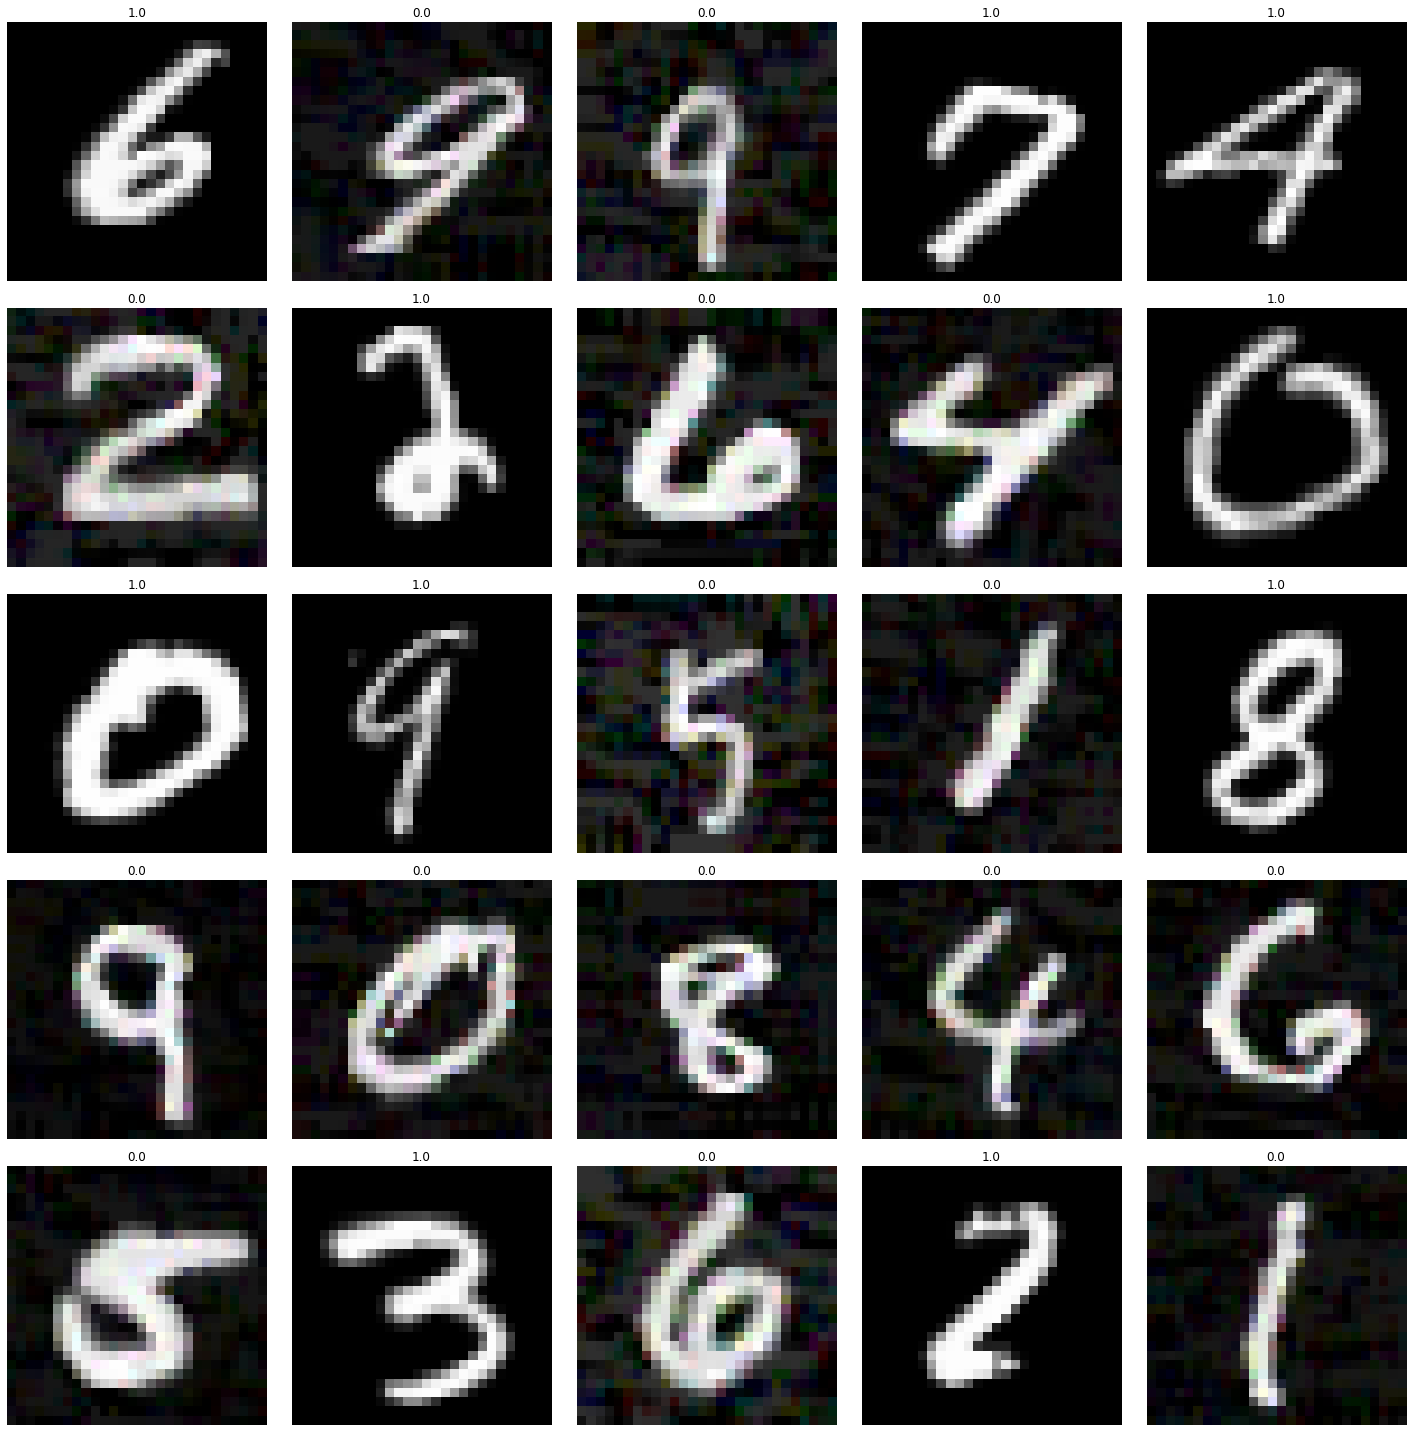

In [4]:
data.show_batch()

In [5]:
learn = Learner(data, new_model(1), metrics=partial(accuracy_thresh,thresh=.4,sigmoid=False))

In [6]:
learn.summary() # Loss function: FlattenedLoss of MSELoss()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [32, 30, 30]         896        True      
______________________________________________________________________
ReLU                 [32, 30, 30]         0          False     
______________________________________________________________________
MaxPool2d            [32, 15, 15]         0          False     
______________________________________________________________________
Conv2d               [32, 15, 15]         9,248      True      
______________________________________________________________________
ReLU                 [32, 15, 15]         0          False     
______________________________________________________________________
MaxPool2d            [32, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 7, 7]           9,248      True      
___________________________________________________

epoch,train_loss,valid_loss,accuracy_thresh,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


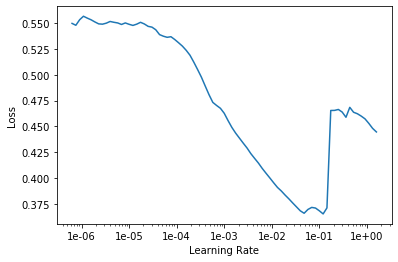

In [7]:
learn.lr_find()
learn.recorder.plot()

In [8]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.009605,0.006540,0.953212,00:21


Note: `lr=1e-3`; using `1e-2` goes to `_accuracy_thresh` of `.5` almost strait away.


TODO: quantify and test the effectiveness of this model and compare with a simple classifier

## Find the most accurate threshold value

What is the best value of `thresh` we can use to split predictions into 2 groups (digits or not digits)

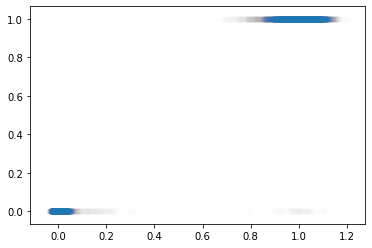

In [9]:
y_preds,y_actuals=get_y_preds_and_actuals(learn)
plt.scatter(y_preds.cpu(), y_actuals.cpu(), alpha=.005);

In [10]:
opt_acc,opt_thresh=search_optimal_thresh(0,.1,y_preds,y_actuals)
print(f'Using threshold of {round(opt_thresh,3)} gives us an accuaracy of {round(opt_acc, 3)}')

Using threshold of 0.4 gives us an accuaracy of 0.996


as expected, these adversarial examples are really easy to spot ... need to find a way to make better adversarial examples

In [11]:
# we'll need access to the best thresh value at inference time
learn.model.opt_thresh=round(opt_thresh,3)

## Save everything needed to make predictions

In [12]:
# remove metrics so we don't need `_accuracy_thresh` available at inference time
learn.metrics=[]
learn_export_file_name,data_export_file_name=save('mnist-or-fgsm',learn,data)

### See if the model is consistently accurate across classes of digits

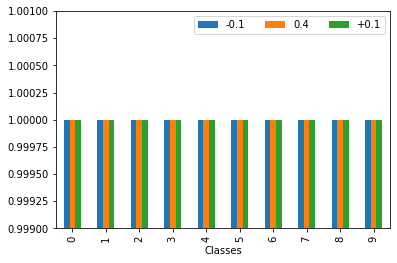

In [14]:
regressor_acc_vs_classes(learn,ylim=(.999,1.001))